In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

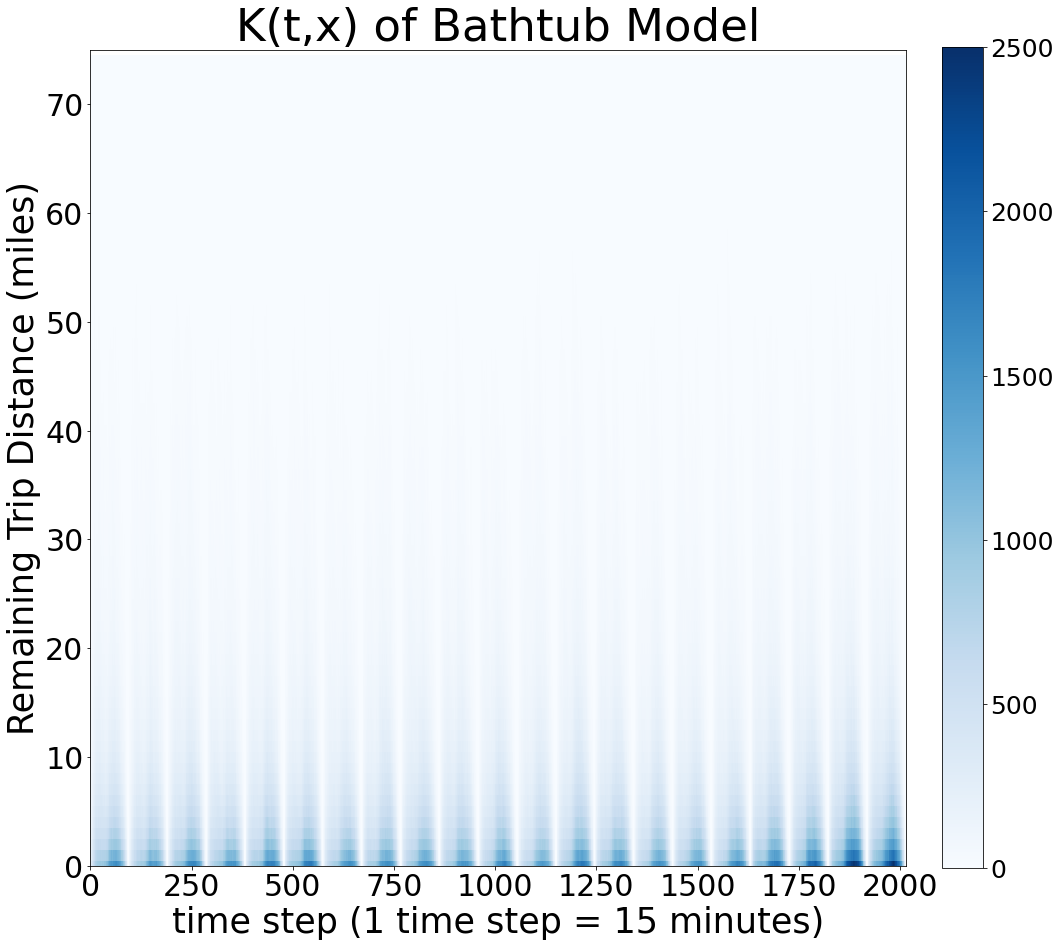

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,20,1]) 
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0106106135726599 0.020499147169859819 0.00072207997545998225 1.094987344545122
0.00871676663754074 0.016815756825459195 0.00061777644962228569 0.9942130926197345
0.0082129689623266829 0.015945817127707047 0.00048012079694631732 0.9681133706879108
0.0076127756471841453 0.014875761771078673 0.00034978952328961746 0.9349339100085612
0.0063274970287338335 0.012370804943251214 0.00028418911421645261 0.8522506202748397
0.0050780717394869309 0.0095699380059249585 0.000586205473048903 0.7524348814068055
0.0050162332544947579 0.0094108860721182838 0.00062158043687123173 0.7451718506403529
0.0049980414149178413 0.0093014665554599363 0.00069461627437574717 0.7403542796163705
0.0049845733856831243 0.0093066563977099344 0.00066249037365631418 0.7403886463504213
0.0049288019575987581 0.009188097835938493 0.00066950607925902344 0.7355972342345054
0.0047701501504242867 0.0089340869907955037 0.00060621331005306989 0.7248973993651476
0.0045999653482218152 0.0086127799265881717 0.00058715076985545861 0

0.003178708814386302 0.005441167625897067 0.00091625000287553658 0.5701457268949256
0.0031786676109558615 0.0054397990116835113 0.000917536210228212 0.5700856165844439
0.0031785889060617746 0.0054399888022044589 0.00091718900991909073 0.570108607852388
0.0031784738971863177 0.0054431131721441768 0.00091383462222845819 0.5702835061169055
0.0031782988771160282 0.0054482890759072807 0.00090830867832477583 0.5705576454309512
0.0031779616034558326 0.0054570290926981456 0.00089889411421351974 0.5710084230938639
0.0031776764145589617 0.0054637894857765459 0.0008915633433413772 0.571353355436994
0.0031772591168650836 0.0054626652575632878 0.00089185297616687915 0.5712630560484837
0.0031769491271292803 0.0054568129667772487 0.00089708528748131213 0.5709664027071605
0.003176699765329259 0.00544683258628433 0.00090656694437418793 0.5704764628965808
0.0031766287812723319 0.0054392669076926189 0.00091399065485204482 0.5700748282549731
0.0031765263631749721 0.005441211238183568 0.0009118414881663761

0.0031622480514977031 0.0054331170602848842 0.00089137904271052216 0.5694935524870736
0.0031619229386403787 0.0054250006452891764 0.00089884523199158111 0.5690970412594075
0.0031615915528200329 0.0054199506633338182 0.00090323244230624763 0.568859421049517
0.0031607697663934356 0.0054046410299552431 0.000916898502831628 0.5680815568419806
0.003160340365817302 0.0053869772248749054 0.00093370350675969869 0.5672471075868553
0.0031588024561390415 0.0053891956564578866 0.00092840925582019656 0.5672784557516125
0.0031584106804140432 0.005400047933603761 0.00091677342722432564 0.5677938757237325
0.0031580161099599349 0.0054102837018070926 0.00090574851811277713 0.5683094732071858
0.0031577198286196432 0.005412521024208505 0.00090291863303078128 0.568395069666334
0.0031574670578859575 0.0054148205467133646 0.00090011356905855052 0.568511394987796
0.0031570754713445785 0.0054115324825091014 0.00090261846018005552 0.5683334023377075
0.0031561837112983478 0.0054052236977752835 0.0009071437248214

0.0030647688219786404 0.0052855305850400035 0.00084400705891727712 0.5612934430548058
0.0030646447517646354 0.0052823904983324106 0.00084689900519685989 0.561146031639786
0.0030645027025346548 0.005282714220517775 0.00084629118455153442 0.561172019191259
0.0030642125838964019 0.0052798198062507552 0.00084860536154204836 0.5610280511563075
0.0030637006554427785 0.0052784544271915739 0.00084894688369398306 0.560958187079164
0.0030634450559784941 0.0052818954111892094 0.00084499470076777894 0.5611212386867598
0.0030633976452641484 0.0052803622864211084 0.00084643300410718872 0.5610412128723503
0.0030633060057722885 0.0052811636651634124 0.0008454483463811648 0.5610720747530454
0.0030632712142563694 0.0052807701280340345 0.00084577230047870394 0.5610506459403718
0.0030632260288625279 0.0052778349405195688 0.00084861711720548671 0.5609018979458636
0.0030631833246649444 0.0052779194877664044 0.0008484471615634846 0.5609252134601339
0.003063157621481244 0.005277079229364658 0.0008492360135978

0.0030584916455620808 0.0052756377107587788 0.00084134558036538256 0.5606966701138532
0.0030584500075182116 0.0052758292343578093 0.000841070780678614 0.5607150868380313
0.0030583460774842347 0.005274085524753459 0.0008426066302150108 0.5606125252786189
0.0030582433470397481 0.0052741196447676835 0.00084236704931181213 0.5606146576651615
0.0030581650645327791 0.0052727123513229392 0.00084361777774261885 0.5605503269885981
0.00305813335599281 0.0052731650639175663 0.00084310164806805394 0.560570846748921
0.0030581020079879771 0.005275085172918967 0.00084111884305698714 0.5606762067403441
0.0030580662018713347 0.005275852687929539 0.00084027971581313032 0.5607210286906402
0.00305803654275988 0.005277557283316559 0.000838515802203201 0.5607971023482311
0.0030579917844938075 0.0052764189913088134 0.0008395645776788016 0.5607420669910258
0.003057943951374026 0.0052763097515128171 0.00083957815123523538 0.5607301488021752
0.0030578833110144355 0.0052758296957626533 0.00083993692626621813 0.5

0.003049284361809344 0.0052430382409019228 0.00085553048271676539 0.5589891525379154
0.003049154969513382 0.0052449478973853082 0.00085336204164145589 0.559086594242563
0.0030489557238900784 0.0052490904920873983 0.00084882095569275835 0.5592823952833675
0.0030487703249433575 0.0052415682851937396 0.00085597236469297567 0.5588701170970239
0.003048532934895497 0.0052424029603686095 0.00085466290942238425 0.5589094541655206
0.0030481734492964351 0.0052375712471657261 0.00085877565142714366 0.5587047324390298
0.0030475375401576724 0.0052388581547084629 0.000856216925606882 0.5587710236463932
0.0030470666726899222 0.0052481262589957256 0.00084600708638411847 0.5592685746841154
0.0030466427100419324 0.005243498350410671 0.00084978706967319339 0.5590243073668458
0.0030459738894855928 0.0052343986673498467 0.00085754911162133911 0.558509270200298
0.0030456307209505646 0.0052410066035492664 0.00085025483835186291 0.558858192566477
0.0030452458933548942 0.0052308811746751976 0.00085961061203459

0.003030455068309059 0.0051949876309092475 0.00086592250570887081 0.5566509042732466
0.0030303322336643649 0.005197275664353092 0.00086338880297563789 0.5567780451389358
0.0030299606848345731 0.0051927669456402663 0.00086715442402888012 0.5564956709187308
0.0030295552509246853 0.0051972489461000028 0.000861861555749368 0.5567641385080404
0.0030291307471465292 0.0051886274288055157 0.00086963406548754257 0.5563397571730588
0.0030288712793097913 0.0051839364416291969 0.00087380611699038534 0.5560696780775319
0.0030288101634502896 0.0051800767681357942 0.00087754355876478525 0.5559787887517348
0.0030285165624331896 0.0051805373723803165 0.00087649575248606231 0.555911976937299
0.0030284184547767468 0.0051830485542371119 0.00087378835531638148 0.5560608627589094
0.0030283014650444094 0.0051823881059384807 0.00087421482415033847 0.5560283337832945
0.0030280564479021875 0.0051795557982818119 0.0008765570975225633 0.5558923544193061
0.00302794181434265 0.0051828322651279613 0.0008730513635573

0.0030129842287023997 0.0051338074086034512 0.00089216104880134788 0.5533881941380124
0.003012845056227011 0.005135368558625412 0.00089032155382861016 0.5534774164181154
0.0030125962076881169 0.005134656115045229 0.00089053630033100436 0.5534692876428532
0.0030123886340850817 0.0051313619456415252 0.00089341532252863807 0.5533058705972496
0.0030122281047277768 0.0051244072014667037 0.00090004900798885024 0.5529580025049458
0.0030121183327474549 0.0051290878179575854 0.00089514884753732419 0.5532200769307581
0.0030119793887933848 0.0051300758912893084 0.00089388288629746113 0.5532792108471883
0.0030116845930463643 0.0051337643243078547 0.00088960486178487383 0.5534767546876356
0.0030114766123775917 0.0051360743038870562 0.000886878920868127 0.5535816852335809
0.0030113151070569597 0.0051372614754246378 0.00088536873868928149 0.5536400090642918
0.0030111719824233345 0.0051382933486441591 0.00088405061620251 0.5536895001259472
0.0030111427531571669 0.0051358053639976586 0.0008864801423166

0.0029961955083135589 0.005102123263448808 0.0008902677531783099 0.5517142874895139
0.0029959595783299381 0.0051002785712716105 0.00089164058538826528 0.5516227054499808
0.0029958111907101709 0.0051004048447469757 0.00089121753667336593 0.5516181829325677
0.0029956152686398444 0.0050983091619393288 0.00089292137534036033 0.5515042092740475
0.0029954546374586733 0.00509582330055517 0.00089508597436217655 0.5513368082496322
0.0029953850944297476 0.0050984354787948485 0.00089233471006464678 0.5514649431439768
0.0029952580071241413 0.0050944813982514523 0.00089603461599683078 0.5512739988890331
0.0029951781050576573 0.0050936777580161711 0.00089667845209914375 0.5512132327404967
0.0029951090531860074 0.0050899730739169206 0.00090024503245509431 0.5510203607162981
0.0029950014606303079 0.0050922568796969731 0.00089774604156364287 0.551129485132147
0.0029948390810596395 0.0050920910399182536 0.0008975871222010257 0.5511026024746344
0.0029945363798174968 0.0050908895446160583 0.00089818321501

0.0029871347041341791 0.0050872674693987806 0.00088700193886957746 0.5506911891316905
0.002987121118303905 0.00508757083262801 0.00088667140397979982 0.55070243829987
0.0029870839562807835 0.0050884019378768181 0.00088576597468474866 0.5507456437236904
0.0029870323846367891 0.0050901086881651857 0.00088395608110839244 0.550835684125696
0.0029869462228782014 0.0050904771255801153 0.00088341532017628763 0.5508618889216944
0.0029867839959765953 0.0050929684427538707 0.00088059954919932017 0.5510209660890786
0.0029866089565620249 0.0050896593013024065 0.000883558611821643 0.5508695004201764
0.0029865039445988264 0.0050931085852149388 0.00087989930398271363 0.5510608954796098
0.0029864445484093609 0.0050930858159844092 0.00087980328083431291 0.5510538351024414
0.0029863248323811968 0.0050848101197271123 0.00088783954503528109 0.5506162036396659
0.0029861978703342785 0.0050840805499352626 0.00088831519073329448 0.5505637552119884
0.0029860997216748239 0.0050826715509469178 0.0008895278924027

0.0029808396235050127 0.0050737214920459272 0.00088795775496409816 0.5501896877587713
0.00298081596929276 0.005074358445439426 0.000887273493146094 0.5502363975096709
0.0029807874089424089 0.005073868319727815 0.00088770649815700289 0.550215150414444
0.0029807527382759219 0.0050734459529116743 0.0008880595236401696 0.550197342281183
0.0029807093169286671 0.00507293463656393 0.00088848399729340424 0.5501622428886271
0.0029806417367934778 0.0050734249702429086 0.00088785850334404694 0.5501871214396711
0.0029805503521409872 0.0050723875205255309 0.0008887131837564434 0.5501405434004817
0.0029805143826094342 0.0050720784150438116 0.00088895035017505671 0.5501116145223954
0.0029804685538107811 0.0050719627450377417 0.00088897436258382066 0.5501290249985893
0.0029804274579865574 0.0050715311947782289 0.00088932372119488606 0.5501016695276069
0.00298038871483665 0.0050700613011997854 0.00089071612847351454 0.5500246074826494
0.0029803421364392813 0.0050705445538592906 0.00089013971901927193 0

0.0029732444190065377 0.0050656287239118332 0.00088086011410124258 0.549905371221133
0.0029729391018872022 0.0050686042525330561 0.000877273951241348 0.5500895508885391
0.0029726444518821207 0.0050619732519936013 0.00088331565177063981 0.5497783603792115
0.0029724022509111056 0.005074054089746898 0.00087075041207531321 0.5504402907609167
0.0029720681680921995 0.0050573522569038387 0.00088678407928056058 0.549556969530101
0.0029719246132810318 0.0050584582943783846 0.00088539093218367867 0.5496355029068263
0.0029717607701309711 0.0050655459050194668 0.00087797563524247518 0.5499986415414404
0.0029715700808024209 0.0050624088324627819 0.00088073132914205979 0.5498344189426326
0.0029714731987513406 0.0050557467415108014 0.00088719965599187961 0.5495069490953762
0.0029713203507122938 0.0050555542302752931 0.00088708647114929442 0.5494991959946388
0.0029712115067202366 0.0050605911976257835 0.00088183181581468937 0.5497941122674012
0.0029710291959229385 0.0050592933043492744 0.0008827650874

0.0029558654262388318 0.0050050780960951531 0.00090665275638251086 0.5467806104641889
0.002955615266091431 0.0050053447429761876 0.00090588578920667456 0.5467564100241743
0.0029554816596168835 0.0050093040064162347 0.00090165931281753237 0.5469909848439453
0.0029554084879788835 0.0050069092257539194 0.00090390775020384785 0.5468847007525349
0.0029552587642264505 0.00500474494801099 0.00090577258044191079 0.5467585032414717
0.0029551927509839206 0.0050068932564092273 0.00090349224555861358 0.5468701781706432
0.0029551215169596103 0.0050066043881094183 0.00090363864580980224 0.5468561312237881
0.00295495187081702 0.0050042141220901174 0.00090568961954392234 0.5467319011235074
0.0029548477791459405 0.0050015905541430181 0.00090810500414886287 0.5466106090866079
0.0029547177927498228 0.0049993250708925486 0.00091011051460709728 0.5464918745289089
0.0029545689528320883 0.0049964108866848139 0.000912727018979363 0.5463340187969197
0.0029544895583548886 0.0049979645520953266 0.000911014564614

0.0029397359636481914 0.0049805814364302457 0.00089889049086613751 0.5451702627618219
0.0029395975768075739 0.0049781825088711261 0.00090101264474402192 0.5450446664163022
0.0029394718217335891 0.004968742464898368 0.00091020117856881037 0.5445274020566503
0.002939327872964019 0.0049697278403321582 0.00090892790559587956 0.5445855538953774
0.002939158149750697 0.0049691464913166556 0.00090916980818473814 0.5445631012718888
0.0029389629336672414 0.0049712267824418921 0.00090669908489259086 0.5446853494951228
0.0029389038356765784 0.0049715235795105856 0.00090628409184257146 0.544712570905434
0.0029387586355853787 0.0049713507379638179 0.00090616653320693978 0.5446947460480512
0.002938681739658906 0.0049678903345334912 0.00090947314478432076 0.5445029536375697
0.0029385494941441314 0.0049669623514827423 0.00091013663680552083 0.5444504183549537
0.00293841305580843 0.0049640906528792394 0.00091273545873762029 0.5443084983219569
0.0029382912696813246 0.0049638952092302376 0.000912687330132

0.0029026887066282451 0.0049344768565572454 0.00087090055669924516 0.5430136976068813
0.0029024052598571174 0.0049335000923428152 0.00087131042737141954 0.5429814001813634
0.0029021175309525186 0.004936064995381865 0.00086817006652317177 0.5431405267870851
0.002901918901881715 0.0049363208121128727 0.00086751699165055706 0.5431762861622704
0.0029017641933950819 0.0049372623029159991 0.00086626608387416464 0.5432207204969906
0.00290165539033079 0.0049371555180053516 0.00086615526265622844 0.5432141594799532
0.0029014510486691 0.0049346619506624037 0.000868240146675797 0.5430733530724858
0.0029011749825681196 0.0049361161948134388 0.00086623377032280023 0.5431468652143278
0.0029010725377432481 0.0049312258288247337 0.0008709192466617629 0.5428624953607205
0.0029008992071699082 0.0049326432144205668 0.00086915519991924938 0.5429850701468637
0.0029007747755626827 0.0049369569273294807 0.000864592623795885 0.5432087182015681
0.0029006665637135586 0.0049364565386262327 0.00086487658880088445

0.0028866376484153735 0.0049178583286852047 0.0008554169681455428 0.5423311646378666
0.0028866084747881161 0.0049172268126305707 0.00085599013694566167 0.5422940565086407
0.002886574022565255 0.0049164976930315858 0.00085665035209892449 0.5422660734979073
0.0028865513886108998 0.0049163548136742837 0.00085674796354751623 0.5422653055738691
0.0028865081416084384 0.0049173634387755455 0.00085565284444133114 0.5423254790921749
0.0028864802061652818 0.0049161505283746793 0.00085680988395588455 0.5422341667137045
0.0028863833016095578 0.0049197350264514527 0.0008530315767676629 0.5424447469021224
0.0028862973237149549 0.0049205016830094163 0.0008520929644204937 0.5424722759975297
0.0028861444472885085 0.00491881469722981 0.00085347419734720716 0.5423693083560501
0.0028859993400129247 0.00491722879695712 0.00085476988306872894 0.5422574055810283
0.0028858628426990654 0.0049158541945883054 0.00085587149080982509 0.5421670379514817
0.0028857509794847562 0.0049155117710880337 0.0008559901878814

0.0028800709797545507 0.004899949624490329 0.00086019233501877267 0.5414464722135127
0.0028799688849193298 0.004901149046255303 0.00085878872358335662 0.5415174007244975
0.0028798796577684366 0.00490251927016364 0.0008572400453732336 0.5415931340564376
0.00287973160776886 0.0049044614379715 0.00085500177756621994 0.5417224384969294
0.0028795859368385061 0.0049107091065224021 0.00084846276715461037 0.5420562331575497
0.0028794885058374695 0.0049069593306070546 0.00085201768106788432 0.5418964653243834
0.002879391496149397 0.0049095928912356842 0.00084919010106310959 0.5420200438763205
0.0028793535860585744 0.0049061374477271883 0.00085256972438996041 0.5418479510853439
0.0028792481759069761 0.0049072234947808227 0.00085127285703312972 0.5418735826828825
0.0028791898411547781 0.0049066680204960522 0.000851711661813504 0.5418534323692508
0.0028791165467467704 0.0049062479500106247 0.000851985143482916 0.5418473774355673
0.0028790302098830119 0.0049061335014521333 0.00085192691831389035 0.

0.0028695487772773236 0.0049016989632906247 0.00083739859126402227 0.5413727957120227
0.0028694502046549249 0.0049018396765025118 0.00083706073280733807 0.5413796102875863
0.002869275523864484 0.0049016069455416192 0.00083694410218734859 0.5413555715121717
0.0028691816053427054 0.0048992980229838482 0.00083906518770156236 0.5412347871348391
0.0028690102685254696 0.0048991336125712021 0.00083888692447973718 0.5411853093181535
0.0028689407089551931 0.0048955026953757582 0.000842378722534628 0.5409545170060326
0.002868856342691223 0.004897132389152444 0.00084058029623000239 0.5410491353206012
0.0028687678633472066 0.0048947941764309784 0.0008427415502634349 0.5409337218263734
0.0028687134498662989 0.0048939040860852883 0.00084352281364730923 0.5408693180692723
0.0028686643974047722 0.0048921913072092066 0.00084513748760033742 0.5407678022803039
0.0028685951949991503 0.0048916992036223267 0.0008454911863759742 0.5407297614877861
0.0028685400042574956 0.0048903045071524856 0.000846775501362

0.0028613254637891257 0.0048703651471848942 0.00085228578039335686 0.5394328028599509
0.0028612828324194885 0.0048683626346649276 0.00085420303017404967 0.5393124015602239
0.00286122584225964 0.0048648024960048063 0.000857649188514473 0.5391110579959582
0.0028611655320714439 0.0048618122829638564 0.0008605187811790314 0.538930316831909
0.0028610898939262146 0.0048609156909362565 0.00086126409691617283 0.5388936086325609
0.0028610198609530912 0.0048618872206970315 0.00086015250120915067 0.538949089091473
0.0028609200716889762 0.0048616722968742327 0.00086016784650371977 0.5389171836316579
0.0028608232453694316 0.0048611976636693775 0.00086044882706948569 0.5388865725736275
0.0028607300617703581 0.0048594880309808276 0.00086197209255988827 0.5387918102321202
0.002860659958882877 0.0048559831552956205 0.00086533676247013366 0.5385790260109582
0.0028605734657877547 0.0048543945217144231 0.00086675240986108576 0.5384843016825033
0.0028604409547392769 0.0048518420965133905 0.0008690398129651

0.0028460769227213953 0.0048332522097360546 0.00085890163570673554 0.5370912764779098
0.0028458870855141813 0.0048326662769807927 0.00085910789404756961 0.5370999803752183
0.002845804540666904 0.0048329995840939426 0.00085860949723986569 0.5371153821690648
0.0028456942836590409 0.0048310147422408779 0.00086037382507720426 0.5369928948008191
0.0028456016346979575 0.00483098680825802 0.00086021646113789449 0.5369971563069769
0.0028454742435960749 0.0048262965289011805 0.00086465195829096939 0.5367385985355587
0.0028453263176979986 0.0048260557200004743 0.00086459691539552319 0.5367035478562059
0.0028450976445380952 0.0048257630556362121 0.00086443223343997822 0.5366702130320918
0.00284490942453282 0.0048228465364606671 0.00086697231260497265 0.5365023009032767
0.0028447976597998446 0.0048232397151952815 0.00086635560440440757 0.5365419519244644
0.0028447057641701121 0.004819330794803821 0.00087008073353640346 0.5362953034102848
0.002844608243002983 0.00482342437940682 0.00086579210659914

0.0028343783670466962 0.0048154367794073913 0.00085331995468600078 0.5362753212159528
0.0028342657999964778 0.0048122552398926132 0.00085627636010034266 0.5361214095528286
0.0028337530244502656 0.0048115294622906261 0.000855976586609905 0.5360414352540271
0.0028337400044763147 0.0048148005918857368 0.00085267941706689292 0.5362132431501722
0.0028333831614012744 0.00480957562262552 0.00085719070017702917 0.5359115276399765
0.0028332852913825809 0.0048109455984412632 0.00085562498432389836 0.5359979050550394
0.002833153021242978 0.0048105982784174091 0.00085570776406854708 0.5359810698987042
0.0028330271537121443 0.0048096847890155532 0.00085636951840873494 0.5359225248460561
0.0028329210294822937 0.0048093331965981942 0.00085650886236639375 0.535909733560495
0.0028327905512379116 0.00480865792824528 0.00085692317423054307 0.5358670958881568
0.0028326704309067211 0.0048063403481765432 0.00085900051363689914 0.5357168085951063
0.0028325709841097836 0.0048050697976087763 0.0008600721706107

0.0028258083268540321 0.0048033811401758707 0.00084823551353219368 0.5356729630193177
0.0028257073502350482 0.0048072330183890205 0.000844181682081076 0.535878679831464
0.0028256392555061636 0.0048054783317952217 0.000845800179217105 0.5357888091560311
0.0028255598339819083 0.0048071330683919439 0.00084398659957187275 0.5358811231352929
0.0028255087976128595 0.004805879195233822 0.000845138399991897 0.5358035726716809
0.0028254734190502197 0.0048059745378050229 0.00084497230029541607 0.5358220676194223
0.0028254279352105532 0.0048051318703897158 0.00084572400003139075 0.5357850486509206
0.002825363336335028 0.0048044470970653843 0.00084627957560467159 0.5357543047591387
0.0028252876488925279 0.0048056346504941052 0.00084494064729095074 0.5358128538808732
0.0028252101095550732 0.0048049000555369882 0.00084552016357315794 0.5357599975060542
0.0028251181949183837 0.0048111390506029462 0.00083909733923382107 0.5360832622041141
0.0028250583128618546 0.0048124470171884148 0.00083766960853529

0.0027944782082148364 0.0047189530805694475 0.00087000333586022532 0.531747396171992
0.002794318388324348 0.00471818758910453 0.00087044918754416588 0.5316793828856823
0.0027941295289987188 0.0047175923518934584 0.00087066670610397876 0.5316094906698593
0.0027940404484770322 0.0047135439599813251 0.00087453693697273917 0.5313750976744374
0.0027938994479081909 0.0047129654327005251 0.00087483346311585674 0.5313731771357186
0.002793734524609764 0.0047183765638555654 0.00086909248536396247 0.5316674132339572
0.0027934900509575976 0.0047208774482762539 0.00086610265363894147 0.5317804381737479
0.0027929973048792462 0.0047283813027496364 0.00085761330700885564 0.5321551164490743
0.0027925664154819793 0.0047275168394340789 0.00085761599152988006 0.5321086802125047
0.0027922094013474127 0.0047245214687645937 0.00085989733393023165 0.531979727161906
0.0027920935185805577 0.0047244637873536856 0.00085972324980742925 0.5320044159753528
0.0027920217411433667 0.0047232000467197456 0.00086084343556

0.0027747149332163572 0.0046898210670185134 0.000859608799414201 0.5303291257567996
0.0027745940769067011 0.0046874965657193023 0.00086169158809410015 0.5302282269311284
0.0027745054268662004 0.004687319584872382 0.00086169126886001849 0.5302198799754405
0.002774376250655955 0.0046898285660719975 0.00085892393523991236 0.5303785143454449
0.0027742710533707527 0.0046890265765480331 0.00085951553019347207 0.5303429232184464
0.0027741563825267393 0.0046875950176092631 0.00086071774744421567 0.5302787764280642
0.0027740745161808885 0.0046866920842485093 0.00086145694811326739 0.5302156935708079
0.0027739796167841266 0.0046837757754925038 0.00086418345807574913 0.530059531187945
0.0027739102479648484 0.0046830323075415237 0.00086478818838817313 0.5299974993385461
0.0027738464191305523 0.0046818987071430389 0.000865794131118066 0.529917688577271
0.0027738108609265196 0.0046814348915877914 0.00086618683026524806 0.529886459810409
0.002773754193825024 0.0046813542316085244 0.000866154156041523

0.0027677903840805122 0.0046588043298188718 0.00087677643834215262 0.5286061637932297
0.0027677497722227349 0.0046589961961241138 0.00087650334832135629 0.5286182454468991
0.0027677275525106572 0.0046594448078305858 0.00087601029719072861 0.5286578664766679
0.002767692546882181 0.0046599461929360316 0.00087543890082833009 0.528666416457255
0.0027676760248159294 0.0046594193839398015 0.00087593266569205709 0.5286407368455754
0.0027676707341603461 0.004659330870381383 0.00087601059793930927 0.528639817757389
0.0027676703011604224 0.0046591448782957248 0.0008761957240251201 0.5286328836824312
0.0027676527474287723 0.0046590295700765765 0.00087627592478096788 0.5286328616569982
0.0027676437711549621 0.0046587826534447239 0.00087650488886519993 0.5286238795001753
0.002767631796447673 0.0046583463468261579 0.00087691724606918842 0.5286093408394169
0.0027676288588991123 0.0046589226874230345 0.00087633503037518978 0.5286423348979006
0.0027676197491009963 0.0046580516208084774 0.00087718787739

0.0027643029061482026 0.0046594021022899569 0.00086920371000644874 0.5287361851428564
0.0027641804164766854 0.0046592326450643666 0.000869128187889004 0.528741363359746
0.0027641106670260622 0.0046594232678208881 0.00086879806623123637 0.5287437275338958
0.0027638894156033927 0.0046558089203998718 0.00087196991080691394 0.5285437033811855
0.0027635588613610026 0.0046514517828717874 0.000875665939850218 0.5283157369237531
0.0027632091530954157 0.0046455332490497828 0.00088088505714104806 0.5280049207752144
0.0027629429612821129 0.0046419777105928921 0.00088390821197133391 0.5278115804308241
0.0027626193341748276 0.00463633869898596 0.00088889996936369583 0.5275107140465914
0.0027623852008070581 0.0046360671262446066 0.00088870327536950955 0.5275312207882501
0.0027623130302737724 0.0046348789457024255 0.000889747114845119 0.5274754471366997
0.0027620801036684589 0.00463177044103759 0.00089238976629932841 0.5273380883290013
0.0027618599434129035 0.0046323196740451419 0.000891400212780665 

0.0027520533053782478 0.0046176714798909476 0.00088643513086554852 0.526617720528887
0.0027520297591812804 0.0046183510773217988 0.00088570844104076155 0.5266584642192959
0.0027519792402444132 0.0046197071023574123 0.00088425137813141449 0.5267602111836894
0.0027519442584620292 0.0046196811426027495 0.00088420737432130868 0.526757098123956
0.0027518706432936948 0.0046192590792494661 0.00088448220733792365 0.5267324421178586
0.0027518189836769412 0.0046194080833028483 0.00088422988405103392 0.5267318430472971
0.0027516739549881975 0.0046173710515054625 0.00088597685847093227 0.5266211710490037
0.0027515972059583131 0.0046179734026513394 0.00088522100926528662 0.5266422697600871
0.0027512753271912976 0.0046184217572164564 0.00088412889716613834 0.5266937177028242
0.0027509741028308942 0.0046169828717459206 0.00088496533391586776 0.5266581727071953
0.0027508668037358134 0.0046167985746212352 0.00088493503285039189 0.5266411048168418
0.0027507733634369322 0.0046181638712918371 0.0008833828

0.0027420336297090987 0.0046054752879026179 0.00087859197151557986 0.526040555579323
0.0027418657241052259 0.004606490893884695 0.00087724055432575711 0.5261013954139325
0.0027417325102453817 0.0046091501237057915 0.00087431489678497219 0.5262546877103002
0.0027416546974363023 0.00460990348254624 0.00087340591232636425 0.5263101698174922
0.0027415230039637335 0.0046085266640163037 0.00087451934391116358 0.5262546350657235
0.0027414095031546562 0.0046090042512791345 0.00087381475503017813 0.5262816386711877
0.0027412897731425856 0.0046040848432182145 0.00087849470306695693 0.5260201528058046
0.0027411617498686027 0.0046036613237237858 0.00087866217601342009 0.525974987739641
0.0027410905353525382 0.0046034666164907019 0.00087871445421437472 0.5259474272379164
0.0027409686323543246 0.0046022622155954549 0.00087967504911319453 0.5258595054844625
0.0027408613508574211 0.0046020139964837873 0.000879708705231055 0.5258505506161004
0.00274071529539592 0.0046020774875420237 0.00087935310324981

0.00273302140948476 0.0045999162968083365 0.00086612652216118348 0.5257703644904997
0.002732925280191091 0.0045994964015210584 0.000866354158861124 0.5257453400819664
0.0027328706386678323 0.0046001559856189023 0.0008655852917167625 0.525794073139187
0.0027327972409113914 0.0045998230889319706 0.00086577139289081221 0.5257698631083422
0.0027327417646644623 0.0045975116197395187 0.00086797190958940633 0.5256380714431372
0.0027326909327490033 0.00459825596918167 0.00086712589631633675 0.525692096017504
0.0027326397287656444 0.0045992656766451956 0.00086601378088609288 0.5257495241350442
0.0027325583861150891 0.0046021784742898289 0.00086293829794034888 0.5259179611574946
0.0027324512459811338 0.0046020464869310149 0.00086285600503125239 0.5259005962030607
0.0027323576737479241 0.00460353380726046 0.00086118154023538868 0.5259746567433576
0.0027322709516023219 0.0046057345895813336 0.00085880731362331 0.5261099819712808
0.0027321612997543185 0.0046091001334486363 0.00085522246606000091 0.

0.0027290383785745441 0.0045979831574461177 0.00086009359970297058 0.5260526416006004
0.0027289797000000539 0.0045967861694595977 0.00086117323054051031 0.5260071455133997
0.0027289766677428976 0.00459643778884393 0.00086151554664186435 0.5259883666728844
0.0027289674600398015 0.0045972898758235587 0.00086064504425604408 0.5260322710493093
0.0027289465334351835 0.0045964351730406888 0.00086145789382967818 0.5259912954635627
0.0027288805833884495 0.0045962569537150774 0.00086150421306182125 0.525974066823236
0.0027288218202990676 0.0045961735228130162 0.00086147011778511936 0.5259886156286112
0.002728644284763351 0.0045952104489379942 0.00086207812058870781 0.5259265477413096
0.0027285328285659122 0.0045937913701110883 0.00086327428702073566 0.5258387654962348
0.0027284438709306359 0.0045910566167246163 0.00086583112513665566 0.5256640502725668
0.0027283044537062514 0.0045892440560112262 0.00086736485140127665 0.525568466177141
0.0027282728953169112 0.004591130612534338 0.00086541517809

0.0027205628059730575 0.0045851637451639086 0.00085596186678220647 0.5252785813440213
0.0027205458481585334 0.004586233733083955 0.00085485796323311143 0.5253368770663207
0.0027205374777513757 0.0045854490719337455 0.00085562588356900555 0.5252902337383589
0.0027205260868972919 0.0045851843813769872 0.00085586779241759656 0.5252800911085506
0.0027205163510326657 0.0045854563906950118 0.00085557631137031921 0.5253022993147108
0.0027205106586327631 0.0045854253289153374 0.00085559598835018892 0.525304513609686
0.0027205061945794959 0.0045854691766131364 0.00085554321254585522 0.5253094561945343
0.0027204996550386777 0.0045852040237406 0.00085579528633675554 0.5252946822652412
0.002720490929566572 0.0045851111067321424 0.00085587075240100175 0.5252863074552719
0.0027204829032001897 0.004585039363009435 0.00085592644339094442 0.5252750802126221
0.002720473744331868 0.0045848701290116959 0.00085607735965204015 0.5252602761079097
0.0027204664065704088 0.0045846927124111704 0.0008562401007296

0.0027191242618231186 0.0045854448784045237 0.0008528036452417131 0.5252341649805149
0.0027191199781701992 0.0045855833664046443 0.00085265658993575457 0.5252428436267113
0.0027191189207783238 0.00458524157567823 0.0008529962658784169 0.5252270208108366
0.0027191141935701065 0.0045851319838797477 0.00085309640326046551 0.5252231951434055
0.0027191058974313557 0.0045850339726633618 0.00085317782219934961 0.5252270889350047
0.002719104256389656 0.004585112831104245 0.00085309568167506677 0.5252331383083948
0.0027190965893201481 0.0045854002097171984 0.00085279296892309736 0.5252552131325111
0.0027190859786220532 0.0045858003988494579 0.00085237155839464822 0.5252825600777659
0.0027190784103895364 0.0045862756804091655 0.00085188114036990675 0.525312950575823
0.0027190672051243094 0.004586636027942982 0.0008514983823056367 0.5253389559838998
0.0027190590152085712 0.0045870532212597265 0.0008510648091574161 0.5253611073324281
0.0027190465895505977 0.00458725050811812 0.000850842670983076 0

0.0027137337028540305 0.0045856302743262113 0.00084183713138185007 0.5254175725022402
0.0027137227861931024 0.00458558465728333 0.00084186091510287471 0.525405062485973
0.0027137100481324436 0.0045856133844247157 0.00084180671184017172 0.5254072289788647
0.0027136943163182745 0.00458526120993456 0.00084212742270198856 0.525388714821061
0.00271367998451384 0.004584931273842182 0.00084242869518549759 0.5253639580575135
0.0027136631139105978 0.0045843092121124985 0.00084301701570869741 0.5253292380932616
0.0027136526322591413 0.0045841573925197686 0.00084314787199851391 0.5253159960194966
0.0027136334681066455 0.0045841566400878523 0.00084311029612543862 0.5253250587656458
0.0027136156990287372 0.0045842691203774886 0.00084296227767998583 0.5253374025300965
0.0027136149694433269 0.004584169124173457 0.00084306081471319694 0.5253314636398814
0.0027135876551799333 0.0045839027634839323 0.00084327254687593391 0.5253279788223132
0.0027135717914520503 0.0045835520313253957 0.000843591551578705

0.0027123688575947848 0.0045752599145756825 0.00084947780061388764 0.5249340145774654
0.0027123566025726931 0.0045751840681166412 0.00084952913702874514 0.5249157245785496
0.0027123462080985631 0.0045750456128200679 0.00084964680337705825 0.5248971308665356
0.002712332265299587 0.0045751319719383515 0.00084953255866082285 0.5248989718172321
0.0027123267434343372 0.0045751795233090033 0.000849473963559671 0.5248996339205898
0.0027123203084359723 0.0045752663538340451 0.00084937426303789958 0.5249066789967154
0.0027123123013863513 0.0045755054997943748 0.00084911910297832754 0.5249253788616967
0.0027123046763409958 0.0045759998799479052 0.000848609472734086 0.5249568125043577
0.0027123004041106772 0.0045764057400042935 0.00084819506821706041 0.524980073398929
0.0027122941197286472 0.0045767950688491814 0.00084779317060811293 0.5249966633325494
0.0027122887081638073 0.004577139186715885 0.00084743822961172921 0.5250144298569253
0.002712284117461185 0.0045773500671149377 0.0008472181678074

0.0027072629592105484 0.00457896012823676 0.00083556579018433683 0.5250808499546128
0.002707226376684589 0.0045795174526644441 0.0008349353007047342 0.5251176860319203
0.0027072068038081136 0.00458005632376494 0.00083435728385128729 0.5251521553387519
0.00270704680896061 0.0045790591897416806 0.00083503442817953991 0.5251021164610842
0.0027068790114406454 0.0045781391792086611 0.00083561884367262991 0.5250393575003905
0.0027067740326249604 0.0045774680304509589 0.00083608003479896135 0.525009255026585
0.0027067381807538084 0.0045794497556383412 0.00083402660586927573 0.5251087107661258
0.0027066632459422559 0.0045807249930749508 0.000832601498809561 0.5251814913962504
0.0027066063925963581 0.0045819703307936324 0.00083124245439908406 0.5252575121115232
0.0027065625420756973 0.0045850785593728209 0.00082804652477857371 0.525430263012509
0.0027064652989468368 0.0045852556953786157 0.00082767490251505816 0.5254260766749509
0.0027064389151439539 0.0045850194507195564 0.00082785837956835147

0.0027051379380869712 0.0045810406969750148 0.00082923517919892794 0.525285961604823
0.002705137040965892 0.0045810974915887542 0.00082917659034303015 0.5252896312456606
0.0027051362116361881 0.0045812088229270553 0.00082906360034532077 0.5252974363202713
0.0027051355998734938 0.0045814296777768569 0.00082884152197013018 0.5253120567044851
0.0027051350950419344 0.0045815956109295838 0.00082867457915428513 0.525323276156703
0.0027051343250629497 0.0045816435401086026 0.00082862511001729664 0.5253261578078192
0.0027051329690214055 0.004581832090375007 0.00082843384766780352 0.525337520306946
0.0027051319852009741 0.0045819343658096128 0.00082832960459233522 0.5253439661146019
0.0027051316031024551 0.0045819919647650392 0.0008282712414398707 0.525345601441606
0.0027051313071884278 0.004582051820523997 0.0008282107938528589 0.5253484563401654
0.0027051301896342623 0.0045820516827371118 0.00082820869653141239 0.5253475585780646
0.0027051290342370877 0.0045819456548637713 0.00082831241361040

0.0027048674996842824 0.0045833871522075889 0.0008263478471609762 0.5253791573431076
0.0027048620425720645 0.00458353624689338 0.00082618783825074945 0.5253894929738739
0.0027048460136204272 0.0045825377226309163 0.00082715430460993838 0.5253393187924797
0.0027048341613871759 0.00458241142826091 0.000827256894513442 0.5253310614826758
0.002704821320979765 0.0045829993295245976 0.00082664331243493226 0.5253562292774088
0.0027048081544412367 0.0045840977897391852 0.00082551851914328817 0.5254090154975373
0.0027047986753214711 0.0045842572587774305 0.00082534009186551144 0.5254294905917182
0.002704789276665506 0.0045844493830747507 0.00082512917025626164 0.5254411981889312
0.0027047770032441968 0.0045849328675118886 0.00082462113897650467 0.5254738660550341
0.0027047669093574517 0.0045849497325360566 0.00082458408617884667 0.5254798110033114
0.0027047545854527429 0.0045850197584296828 0.00082448941247580338 0.5254917532555781
0.0027047540697431789 0.0045851028088232867 0.00082440533066307

0.0027017540319603755 0.0045858346766494409 0.00081767338727131006 0.5253311279737531
0.0027017524035152975 0.0045858289399989729 0.0008176758670316223 0.5253281470505152
0.0027017523220858332 0.0045857792406308606 0.00081772540354080585 0.5253251796483758
0.0027017503852310668 0.0045856097421695845 0.0008178910282925487 0.525314557186428
0.0027017482144410044 0.0045854441623154269 0.00081805226656658206 0.525305071312695
0.0027017476817215711 0.0045854496030268256 0.00081804576041631693 0.5253047082966966
0.00270174676699702 0.0045855227206722847 0.000817970813321755 0.5253101115856986
0.0027017461811390557 0.0045856320159784851 0.00081786034629962635 0.5253169798115521
0.0027017452956489131 0.0045857899429233148 0.00081770064837451172 0.5253263820240929
0.0027017449664052794 0.0045857090923829133 0.00081778084042764538 0.5253210934451094
0.0027017448565884515 0.0045856342225522595 0.0008178554906246437 0.5253173565586804
0.0027017437735393076 0.0045857313204243954 0.00081775622665421

0.0026955680133160086 0.0045621744063871483 0.00082896162024486894 0.5244150136940532
0.0026955505832980493 0.0045616428138874759 0.000829458352708623 0.5243940719742873
0.002695506873221364 0.0045614290167378547 0.0008295847297048732 0.5243786880614021
0.0026954679958124369 0.0045619961238729271 0.00082893986775194647 0.5244067864642074
0.0026954302266870662 0.004563088204317 0.00082777224905713294 0.5244589894996536
0.0026954111478044553 0.0045641291010150541 0.0008266931945938562 0.5245141996627345
0.002695369137448121 0.0045658209567565194 0.00082491731813972289 0.5245930206444182
0.0026953238735290732 0.0045662347755772575 0.00082441297148088874 0.5246058202519008
0.0026952459817489588 0.0045661463117635994 0.00082434565173431775 0.5245730250706706
0.0026952136664980661 0.004566165546389638 0.00082426178660649409 0.5245647168775263
0.0026951556557897067 0.0045660957503171756 0.00082421556126223785 0.5245488911280478
0.0026950756424550517 0.0045672499804981538 0.0008229013044119498

In [ ]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [ ]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

In [ ]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

In [ ]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)